# Reporte analítica de datos - Proyecto de Grado II

## Preparación de los datos para el municipio de BUGA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
from pandas.plotting import lag_plot
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
import datetime as datetime

In [2]:
buga = pd.read_csv('../../dengue_data/Buga.csv')
df = pd.DataFrame(buga)
df["FecNot"]=pd.to_datetime(df['FecNot'])

## Pruebas de hipóstesis para determinar si las series de tiempo son estacionarias | DICKEY-FULLER TEST

**Hipótesis nula:** La serie de tiempo no es estacionaria

**Hipótesis del investigador:** La serie de tiempo es estacionaria

*Si el estadístico ADF < Valor crítico entonces rechazo la hipótesis nula*  
*Si el estadístico ADF > Valor crítico entonces acepto la hipótesis nula*

**Se trabajarán las series de tiempo individuales por barrios entre los años 2013 y 2016**

In [3]:
df2 = df[df.Ano.isin([2013, 2016])]
data_model = pd.DataFrame(df2['FecNot'].value_counts().sort_index())
data_model.columns = ['Casos']
data_model.index.name = 'Fecha'

In [4]:
df2

,Id,MesOcurrencia,FecNot,Semana,Ano,Edad,GrupoEdad,Sexo,Barrio,Comuna
864,1124,diciembre,2013-01-25,51,2013,10,5 - 14,M,EL CARMELO,6
884,1147,marzo,2013-05-03,10,2013,45,45 - 60,M,LA HONDA,5
885,1148,marzo,2013-12-03,10,2013,9,5 - 14,F,FRANCISCO RIVERA ESCOBAR,5
886,1149,marzo,2013-03-17,11,2013,48,45 - 60,F,LA CONCORDIA,3
887,1150,marzo,2013-03-16,11,2013,3,1 - 4,M,SANTA BARBARA,2
...,...,...,...,...,...,...,...,...,...,...
2856,53013,agosto,2016-08-18,32,2016,61,> 60,F,DIVINO NINO,3
2857,53014,diciembre,2016-07-12,48,2016,8,5 - 14,M,JOSE MARIA CABAL,4
2858,53015,diciembre,2016-12-12,49,2016,17,15 - 44,F,SANTA BARBARA,2
2859,53016,diciembre,2016-12-15,49,2016,10,5 - 14,M,PALOBLANCO,3


In [5]:
def stationarity_analysis_nb(nb_df, name):
    results = adfuller(nb_df)
    print('Estadístico ADF: %f' % results[0])
    print('p-value: %f' % results[1])
    print('Valor crítico:')
    for key,value in results[4].items():
        print('\t%s: %.3f'% (key,value))

    if results[0] < results[4]["5%"] :
        print("Rechazo Ho: La serie de tiempo es estacionaria")
        nb_df.plot(kind='line', figsize=(30,5))
        plt.title(name)  
        plt.ylabel("Número de casos")    
    else :
        print("Acepta Ho: La serie de tiempo no es estacionaria\n\nDebido a que la serie de tiempo no es estacionaria se procede a transformarla:\n")
        nb_df = nb_df.diff().dropna()
        results = adfuller(nb_df)
        print('Estadístico ADF: %f' % results[0])
        print('p-value: %f' % results[1])
        print('Valor crítico:')
        for key,value in results[4].items():
            print('\t%s: %.3f'% (key,value))

        if results[0] < results[4]["5%"] :
            print("Rechazo Ho: La serie de tiempo es estacionaria")
        else :
            print("Acepta Ho: La serie de tiempo no es estacionaria")

        nb_df.plot(kind='bar')

In [6]:
def assign_zeros(nb_df) :
    day_delta = datetime.timedelta(days=1)
    start_date = datetime.date(2013, 1, 1)
    end_date = datetime.date(2017, 1, 1)

    list = []

    for i in range((end_date - start_date).days):
        date = start_date + i*day_delta
        try: 
            list.append(nb_df.at[date,'Casos'])
        except:  
            list.append(0)
            
    final_model = pd.DataFrame(columns=('Fecha', 'Casos'))

    for i in range((end_date - start_date).days):
        date = start_date + i*day_delta
        final_model.loc[len(final_model)]=[date, list[i]]
        
    return final_model

Se completan los registros (1461) entre los años 2010 y 2018. El día donde no haya un acaso se agrega con un 0.

**Después para cada barrio se hace su respectivo análisis de estacionariedad**

Estadístico ADF: -9.571270
p-value: 0.000000
Valor crítico:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Rechazo Ho: La serie de tiempo es estacionaria
Estadístico ADF: -5.704352
p-value: 0.000001
Valor crítico:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Rechazo Ho: La serie de tiempo es estacionaria
Estadístico ADF: -7.810171
p-value: 0.000000
Valor crítico:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Rechazo Ho: La serie de tiempo es estacionaria
Estadístico ADF: -16.838208
p-value: 0.000000
Valor crítico:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Rechazo Ho: La serie de tiempo es estacionaria
Estadístico ADF: -6.227042
p-value: 0.000000
Valor crítico:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Rechazo Ho: La serie de tiempo es estacionaria
Estadístico ADF: -5.936882
p-value: 0.000000
Valor crítico:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Rechazo Ho: La serie de tiempo es estacionaria
Estadístico ADF: -36.547621
p-value: 0.000000
Valor crítico:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Rechazo Ho: La serie de tiempo es est

/Users/jorge/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Estadístico ADF: -12.095823
p-value: 0.000000
Valor crítico:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Rechazo Ho: La serie de tiempo es estacionaria


/Users/jorge/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Estadístico ADF: -5.521403
p-value: 0.000002
Valor crítico:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Rechazo Ho: La serie de tiempo es estacionaria


/Users/jorge/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Estadístico ADF: -5.595639
p-value: 0.000001
Valor crítico:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Rechazo Ho: La serie de tiempo es estacionaria


/Users/jorge/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Estadístico ADF: -38.341660
p-value: 0.000000
Valor crítico:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Rechazo Ho: La serie de tiempo es estacionaria


/Users/jorge/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Estadístico ADF: -6.238194
p-value: 0.000000
Valor crítico:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Rechazo Ho: La serie de tiempo es estacionaria


/Users/jorge/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Estadístico ADF: -9.129942
p-value: 0.000000
Valor crítico:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Rechazo Ho: La serie de tiempo es estacionaria


/Users/jorge/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Estadístico ADF: -4.872575
p-value: 0.000039
Valor crítico:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Rechazo Ho: La serie de tiempo es estacionaria


/Users/jorge/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Estadístico ADF: -6.574351
p-value: 0.000000
Valor crítico:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Rechazo Ho: La serie de tiempo es estacionaria


/Users/jorge/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Estadístico ADF: -13.678626
p-value: 0.000000
Valor crítico:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Rechazo Ho: La serie de tiempo es estacionaria


/Users/jorge/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Estadístico ADF: -8.379574
p-value: 0.000000
Valor crítico:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Rechazo Ho: La serie de tiempo es estacionaria


/Users/jorge/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Estadístico ADF: -37.545342
p-value: 0.000000
Valor crítico:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Rechazo Ho: La serie de tiempo es estacionaria


/Users/jorge/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Estadístico ADF: -37.599993
p-value: 0.000000
Valor crítico:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Rechazo Ho: La serie de tiempo es estacionaria


/Users/jorge/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Estadístico ADF: -25.210809
p-value: 0.000000
Valor crítico:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Rechazo Ho: La serie de tiempo es estacionaria


/Users/jorge/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Estadístico ADF: -5.457799
p-value: 0.000003
Valor crítico:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Rechazo Ho: La serie de tiempo es estacionaria


/Users/jorge/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


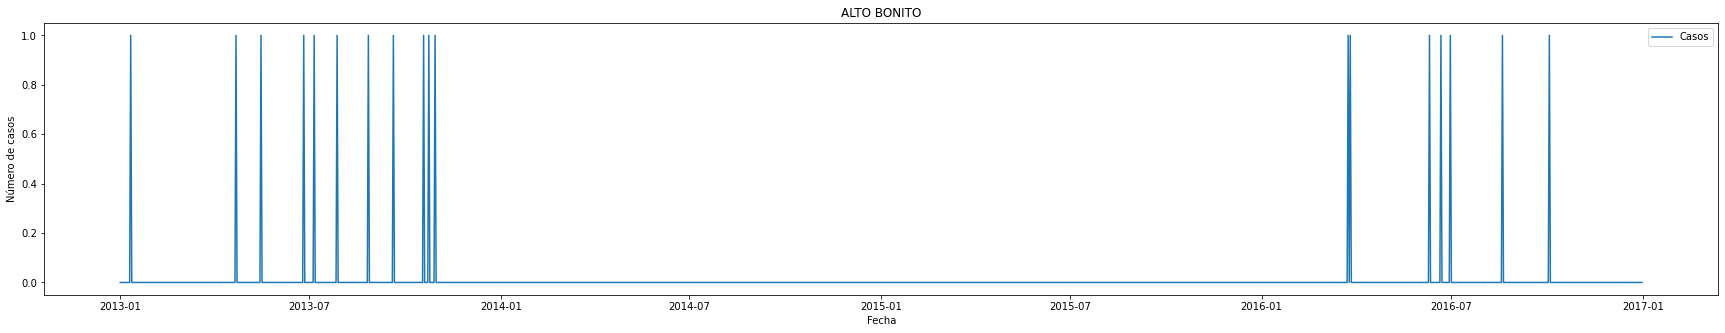

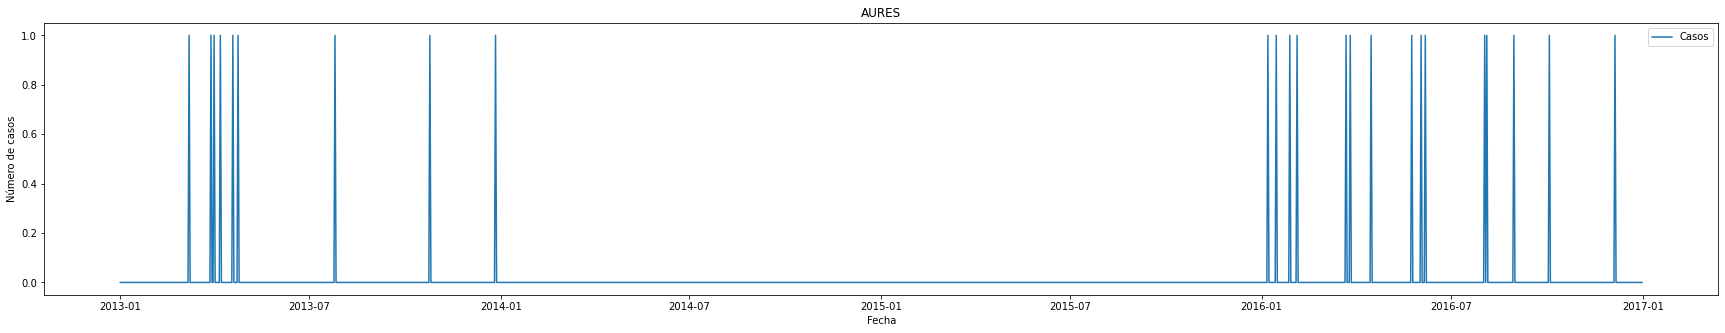

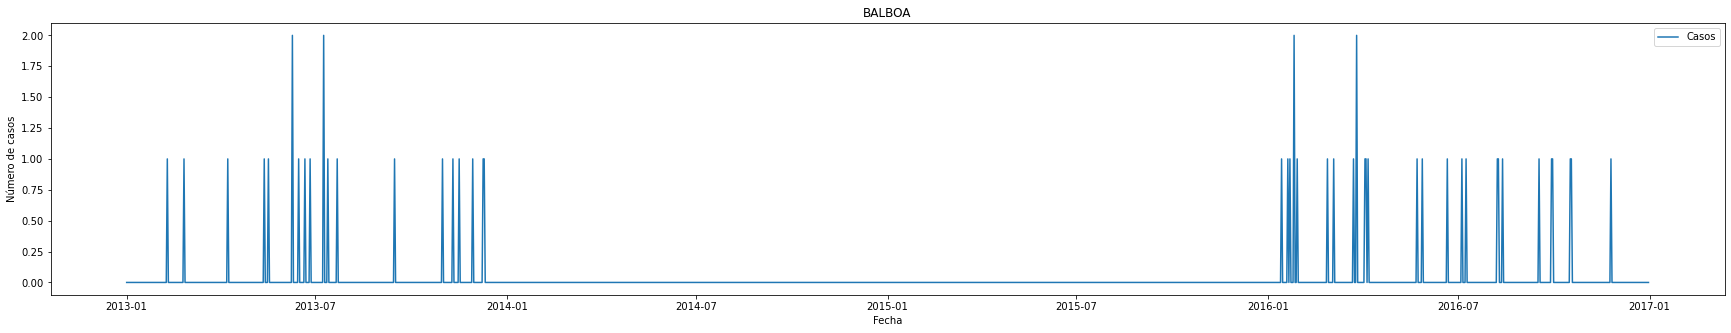

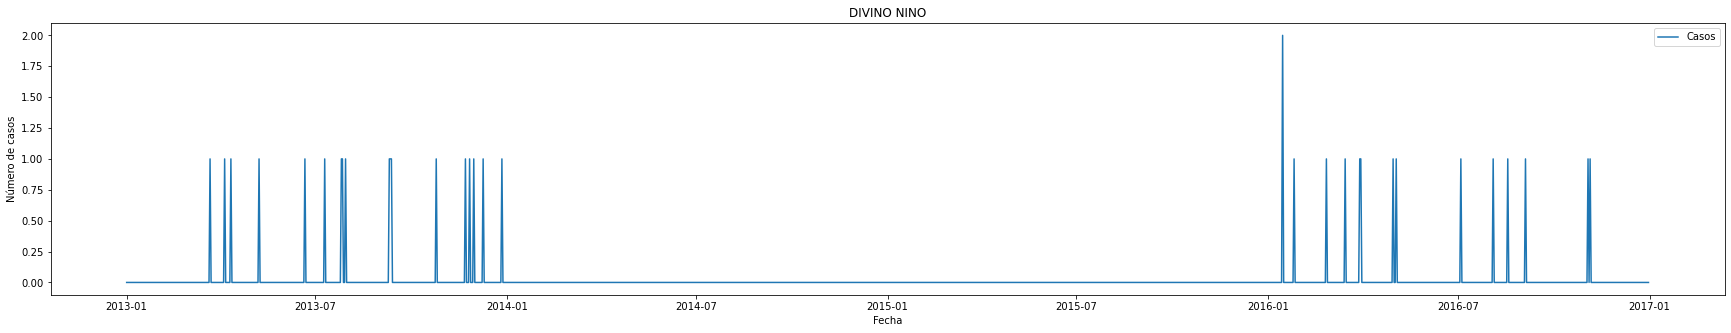

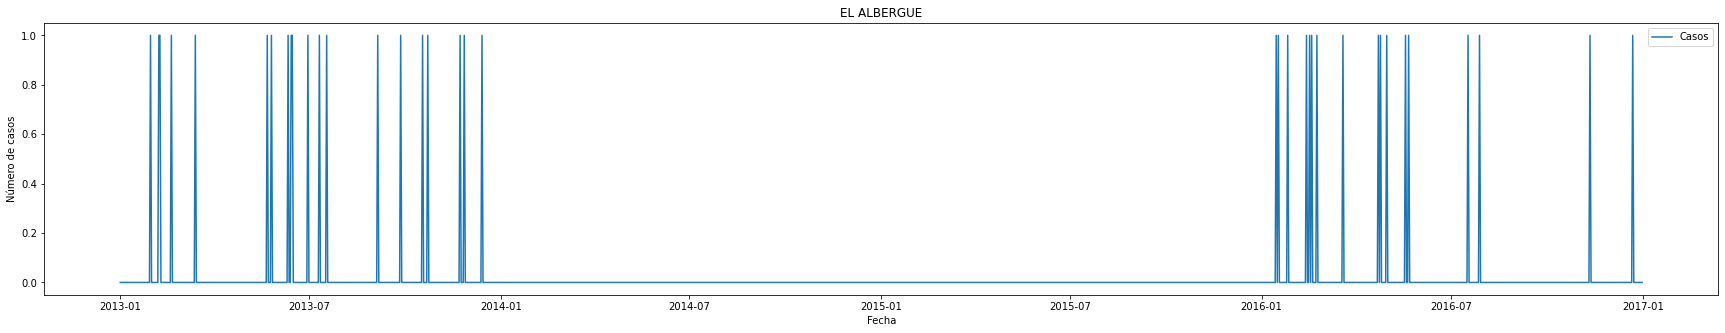

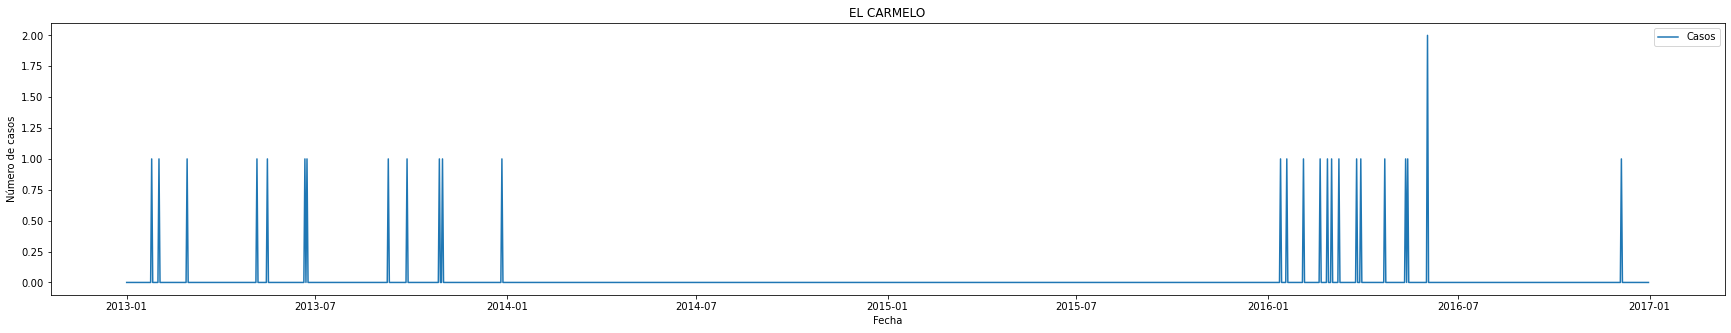

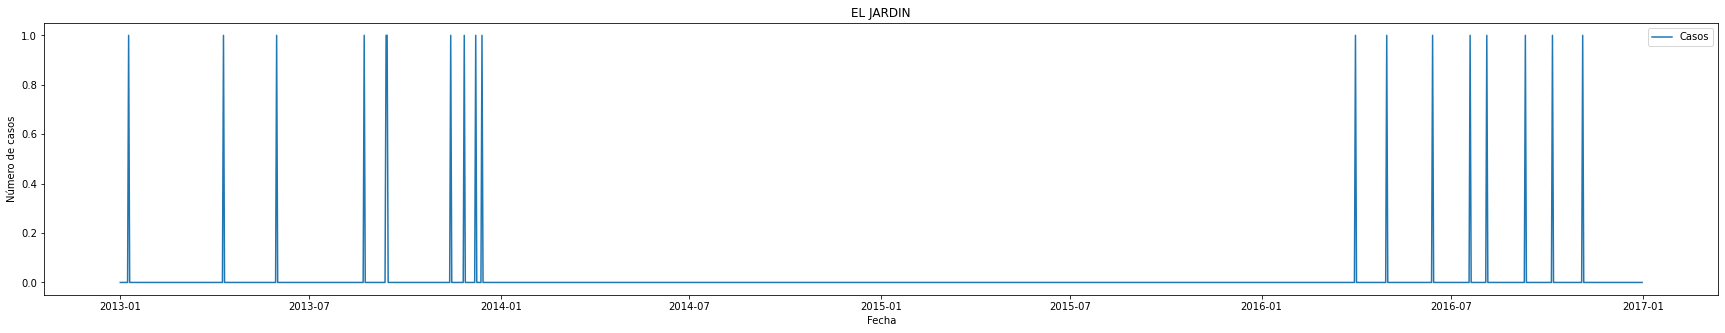

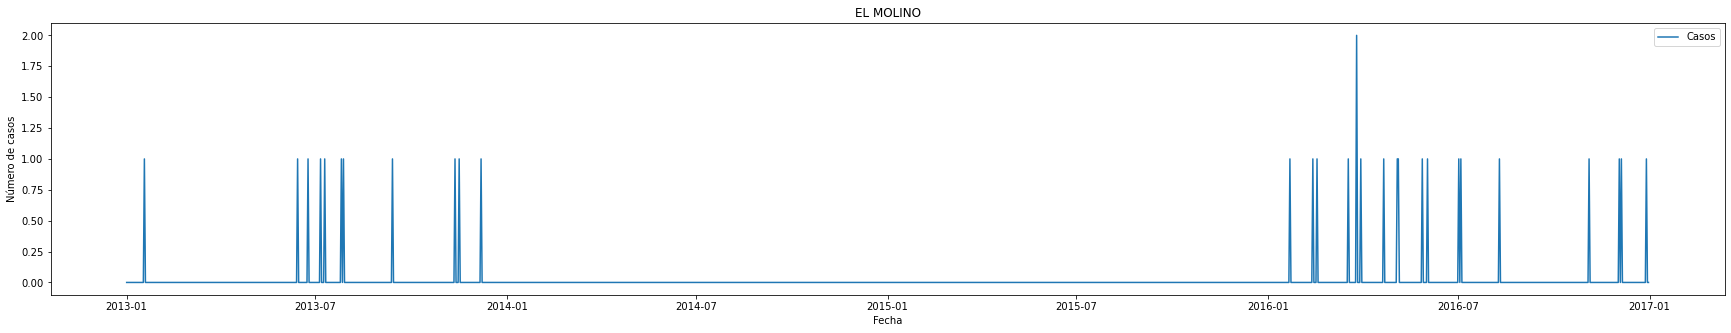

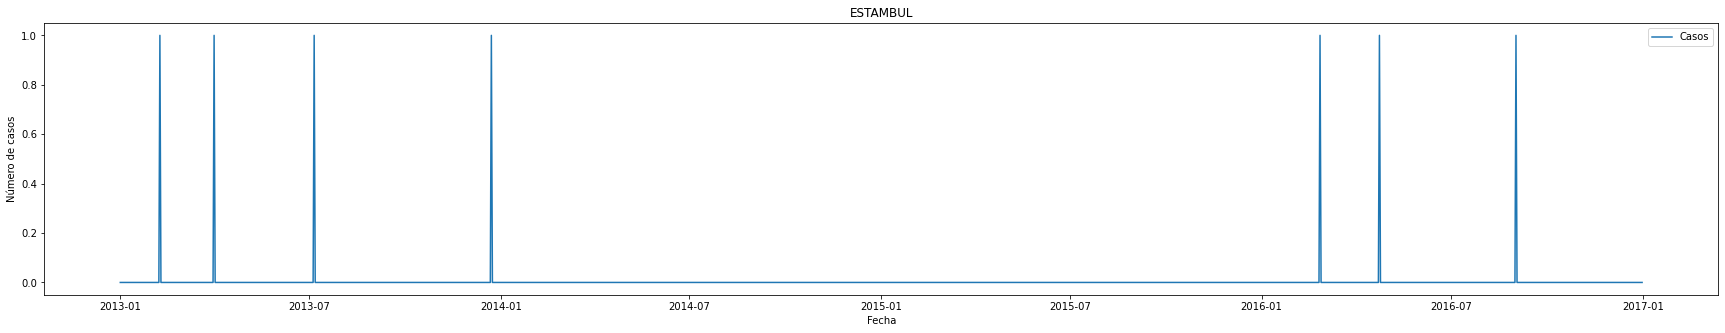

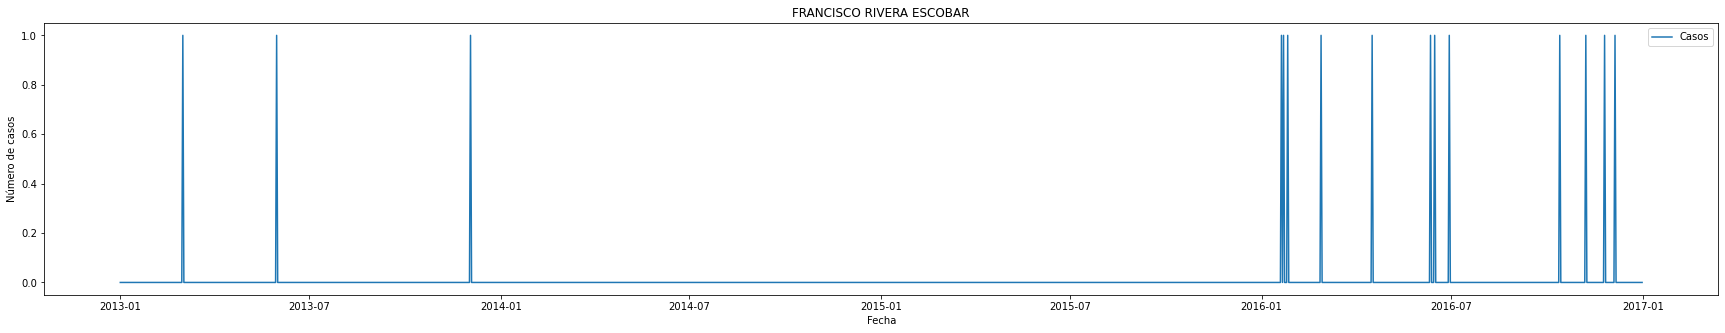

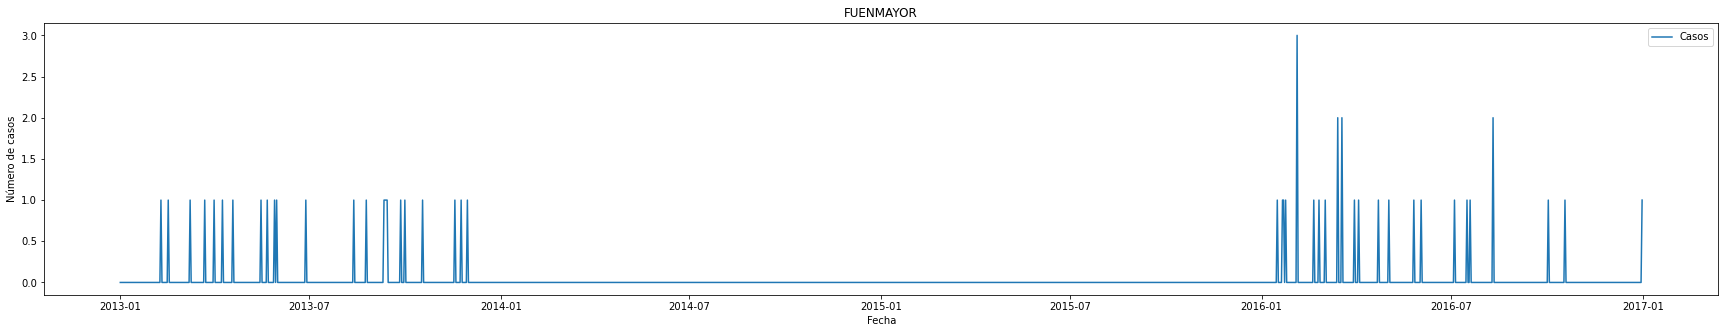

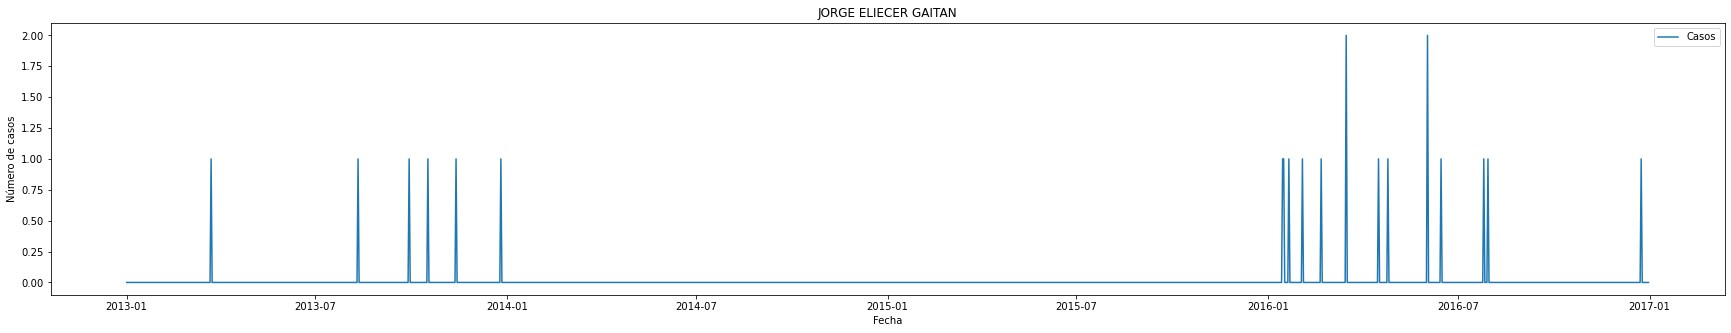

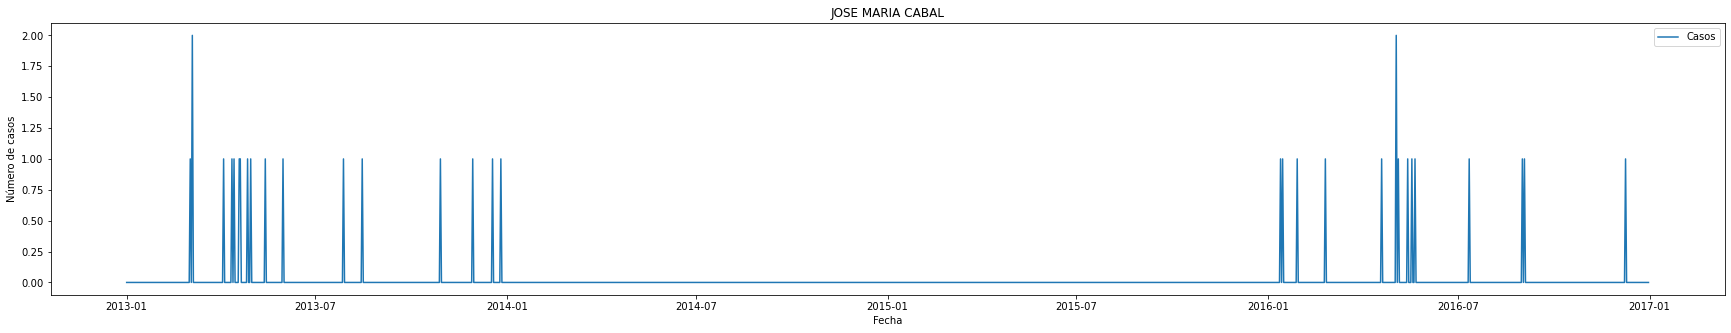

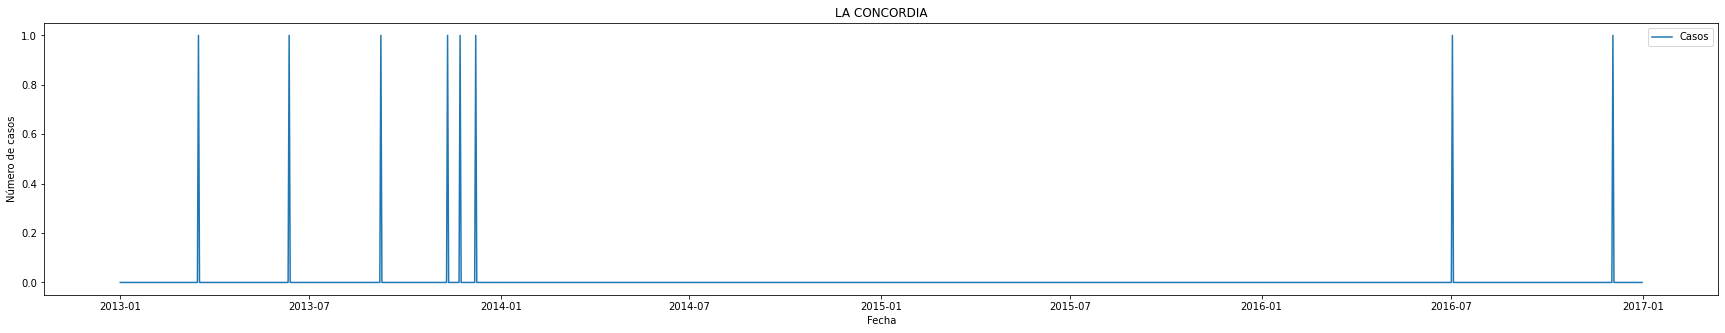

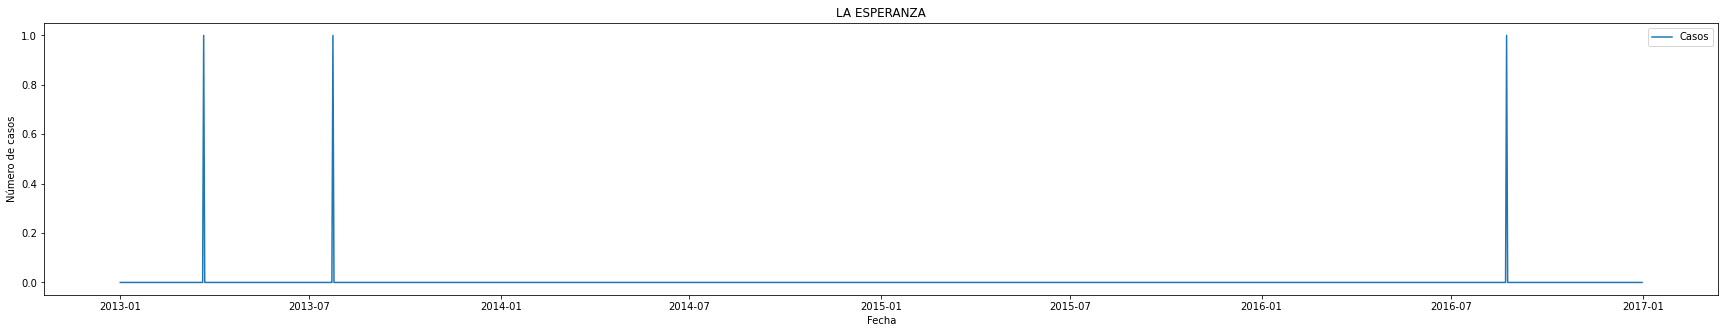

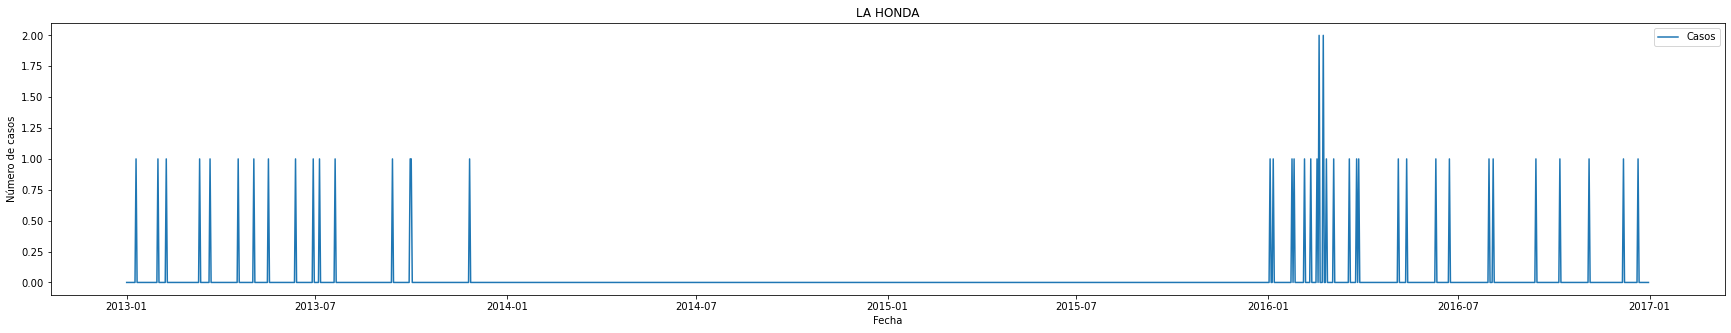

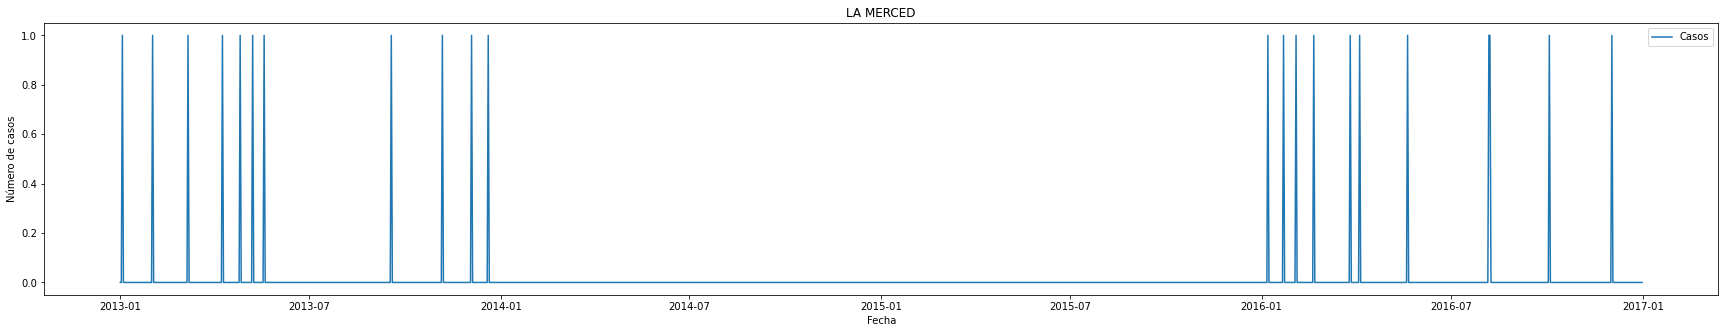

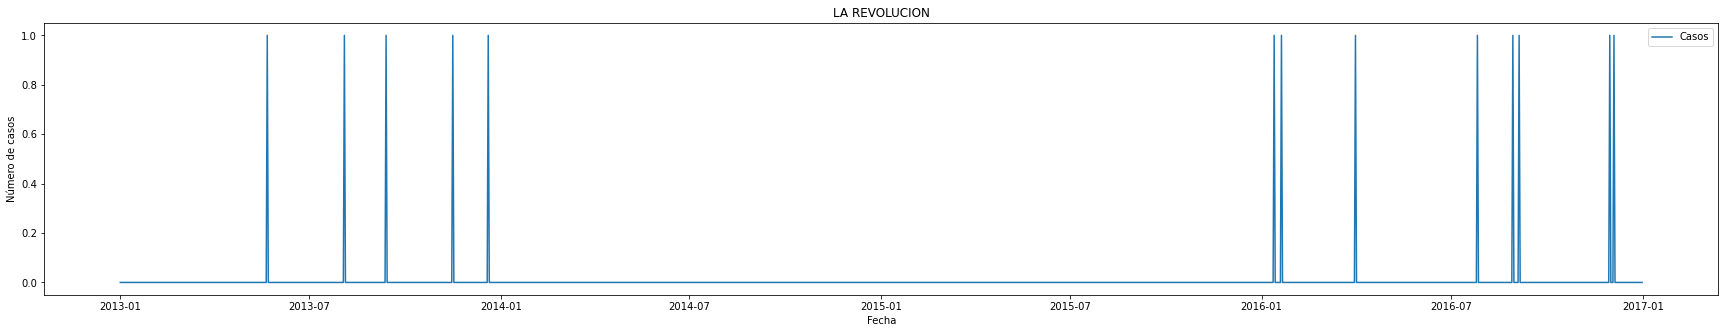

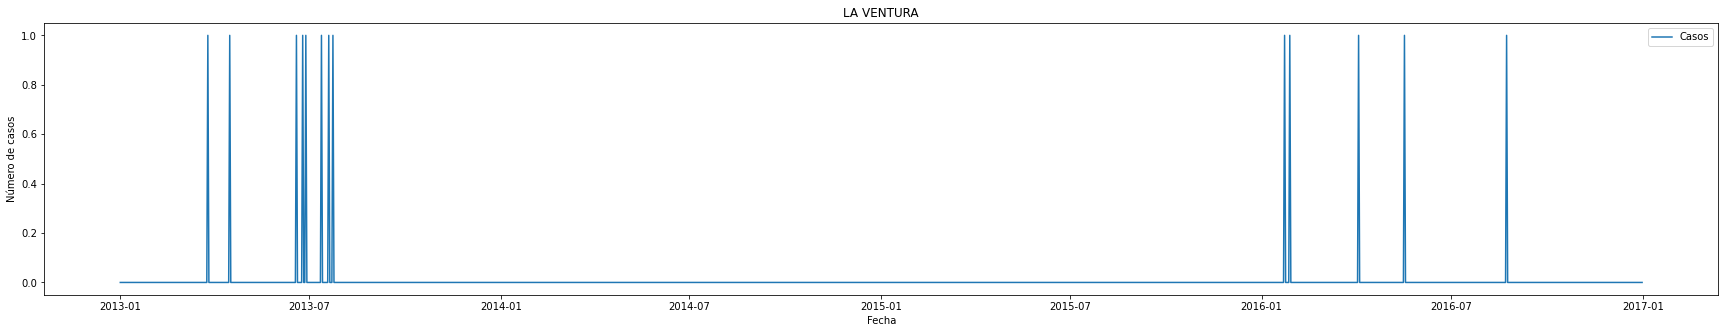

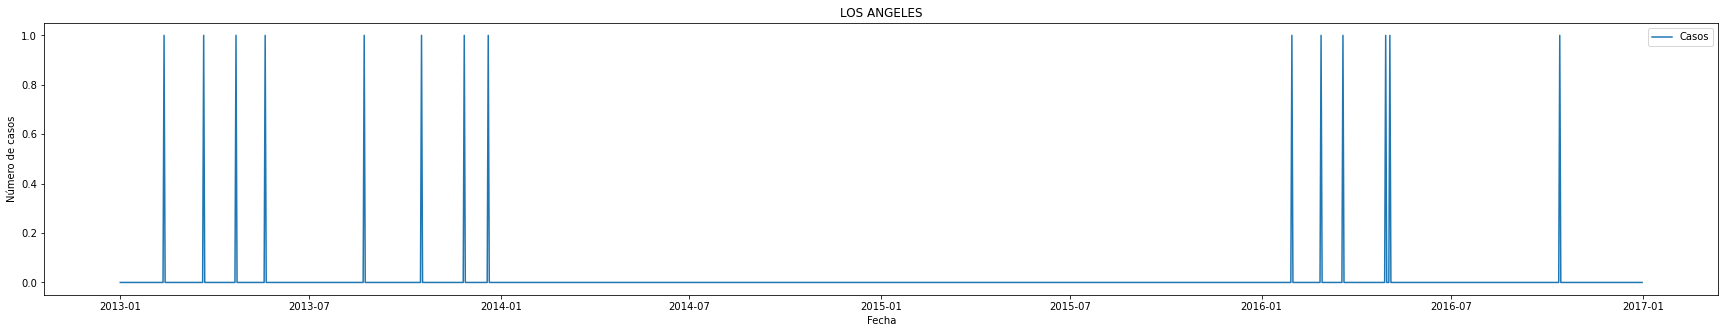

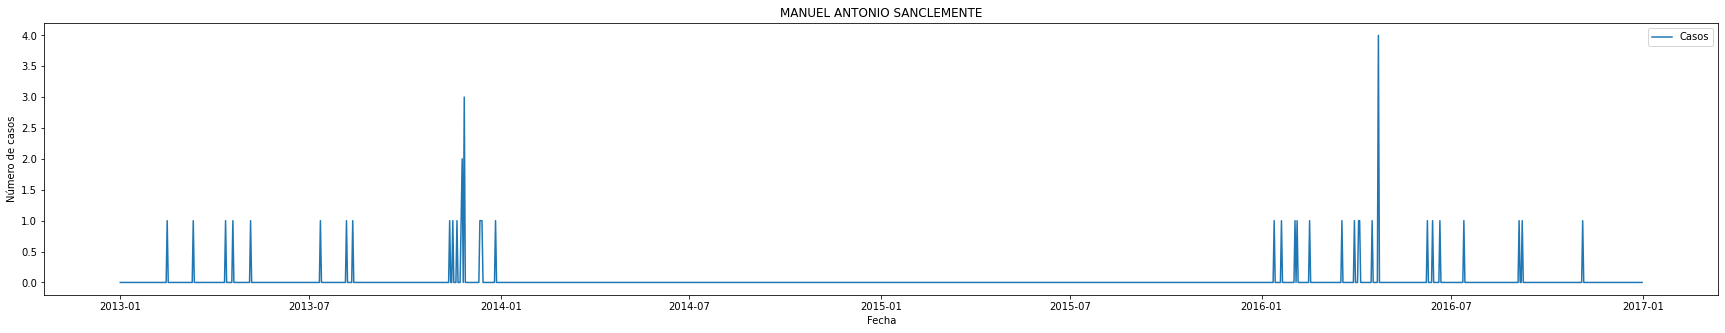

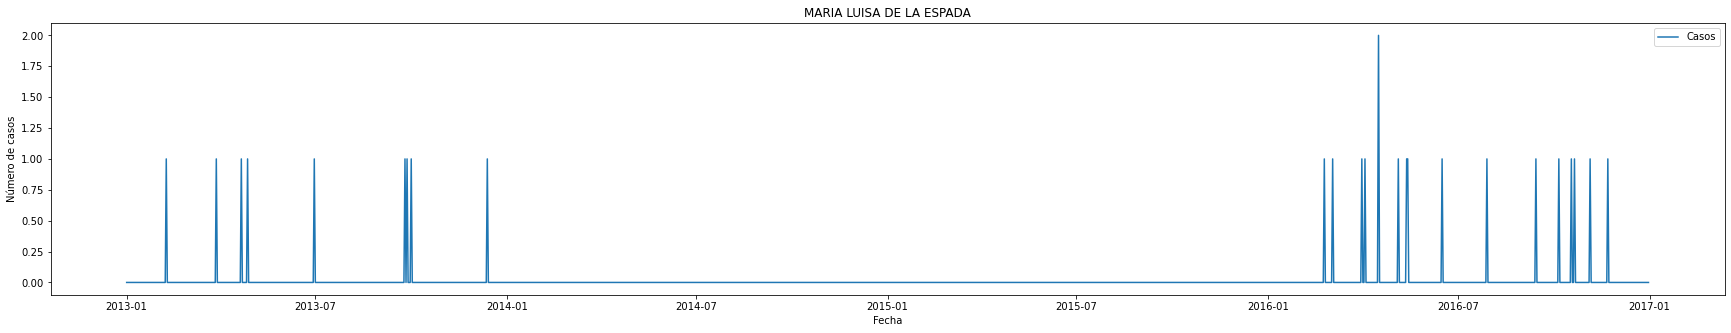

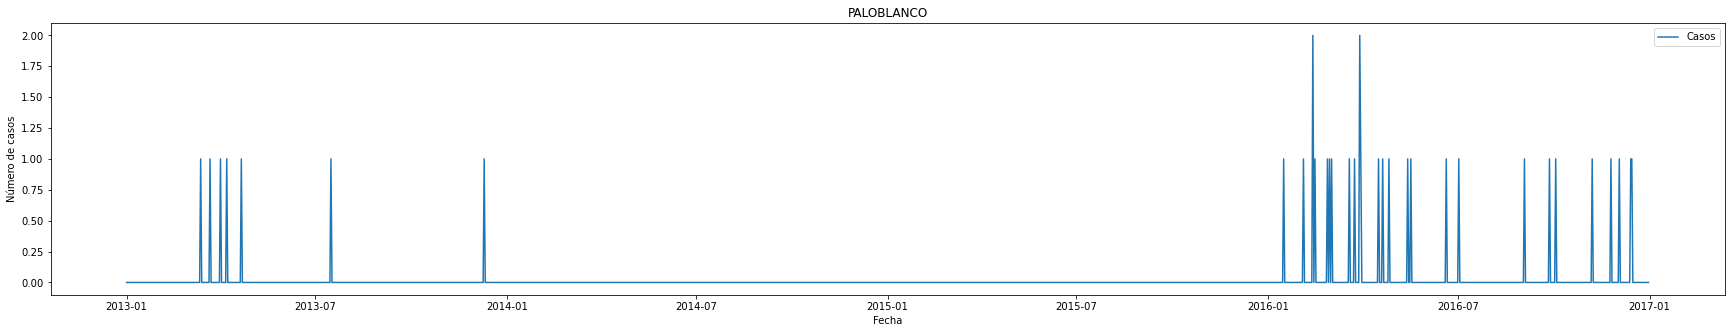

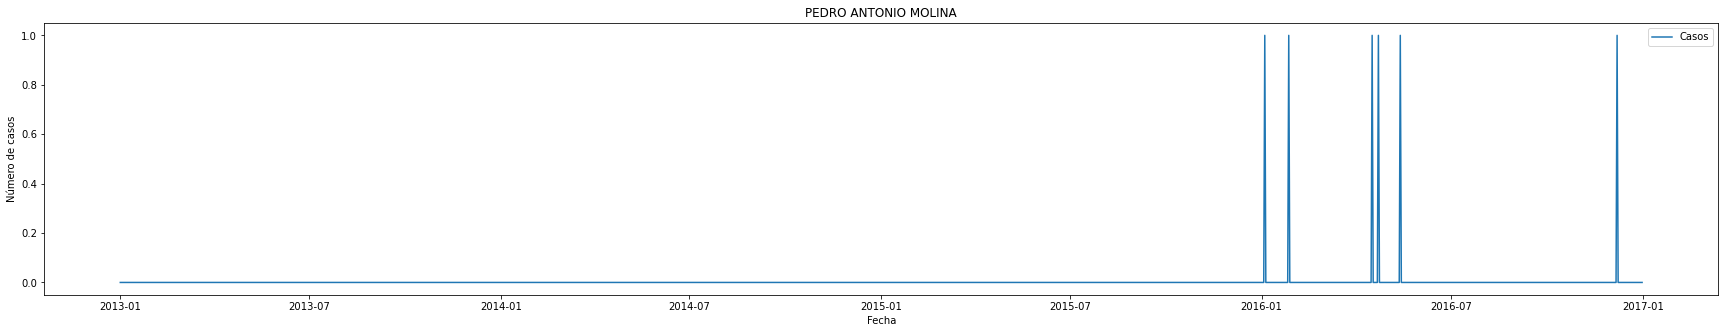

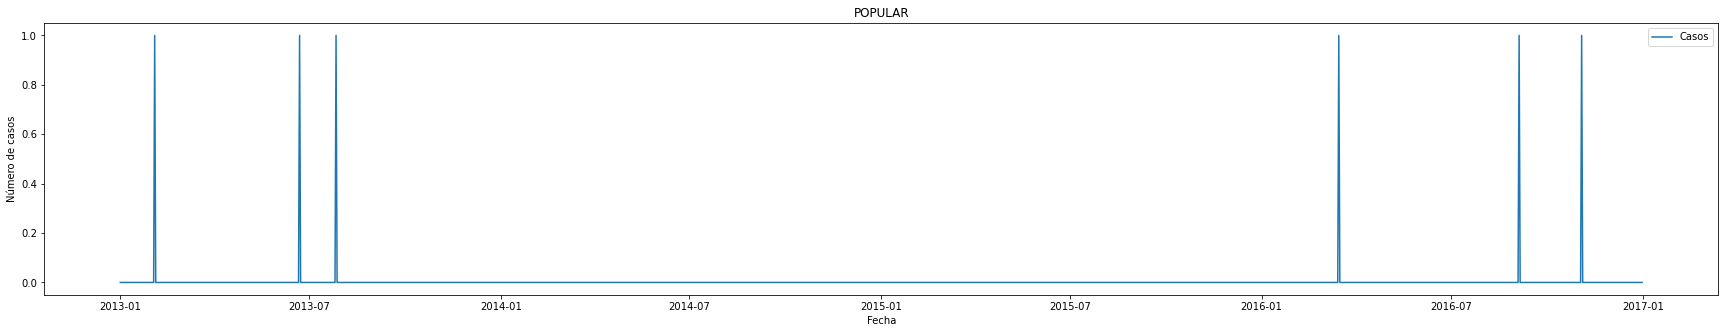

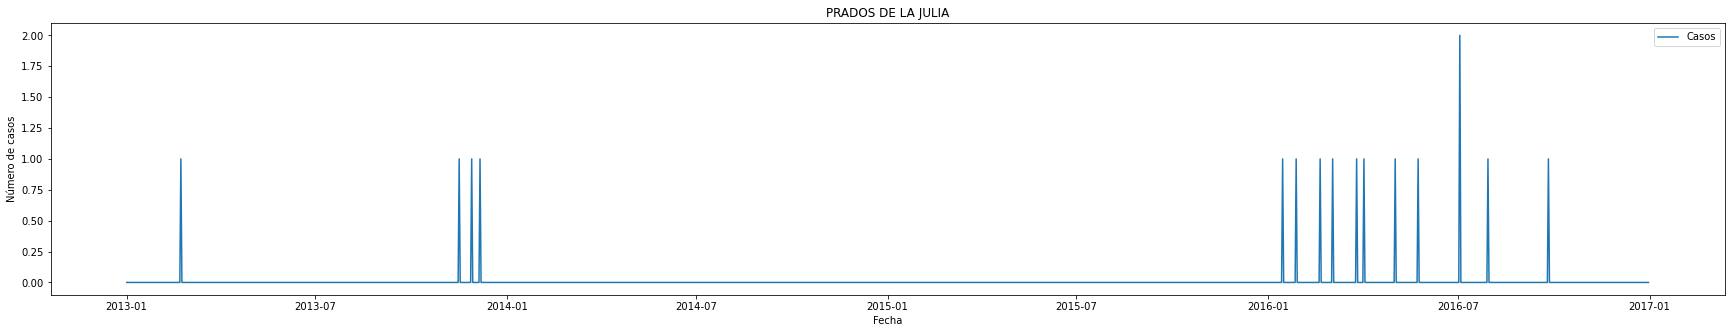

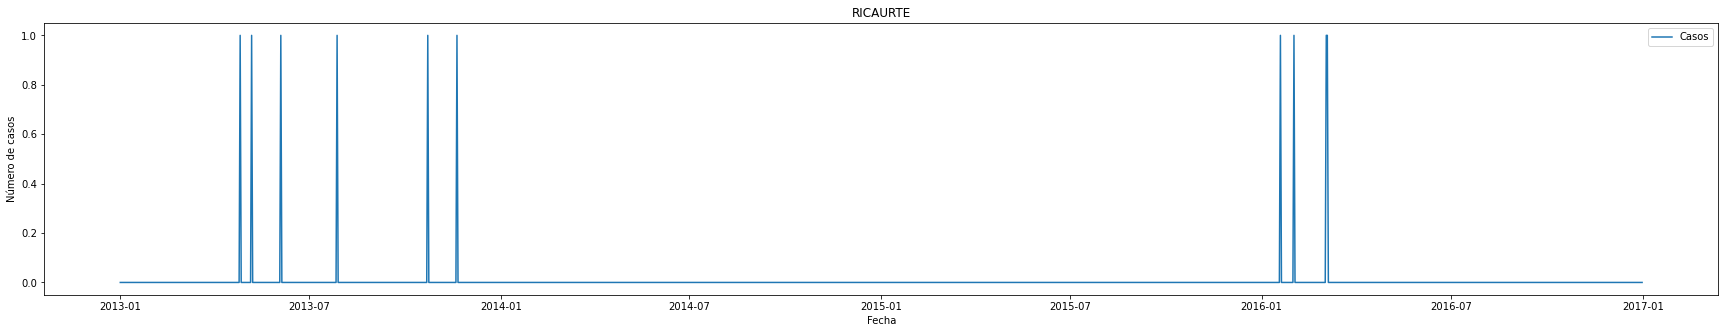

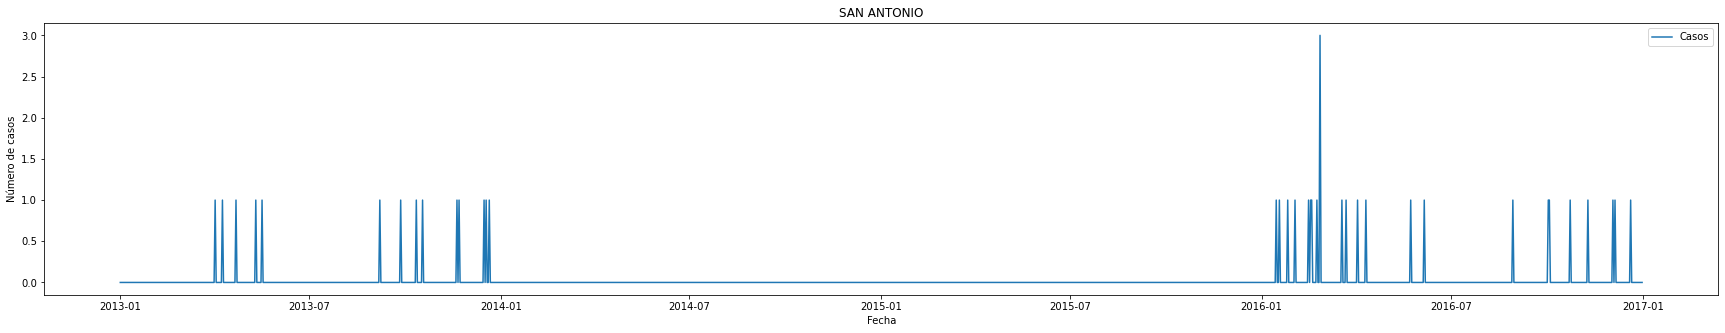

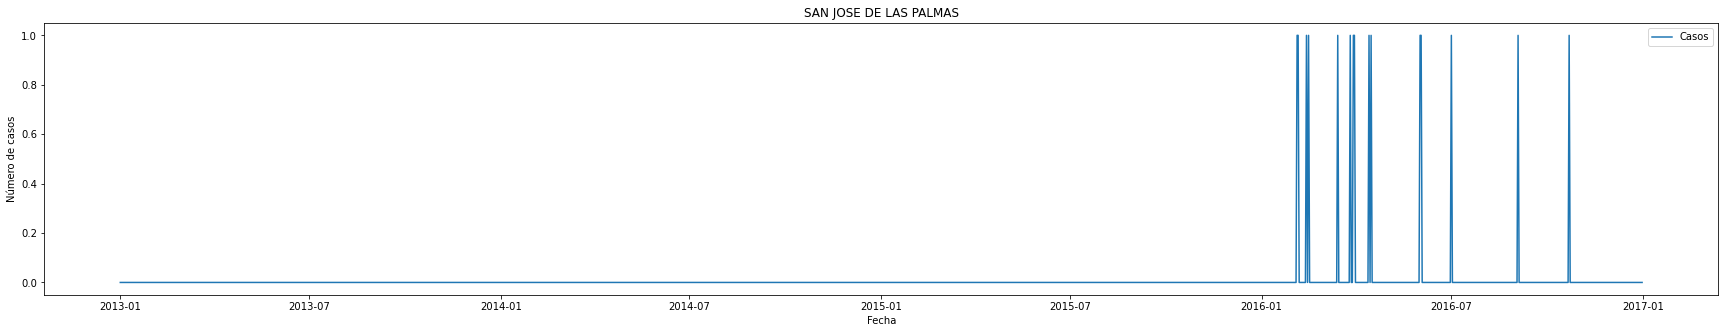

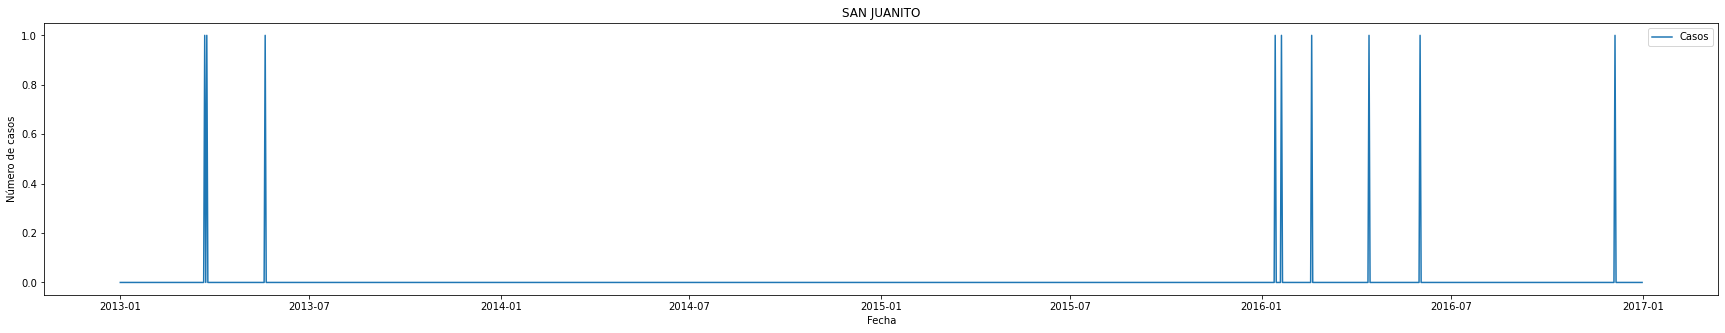

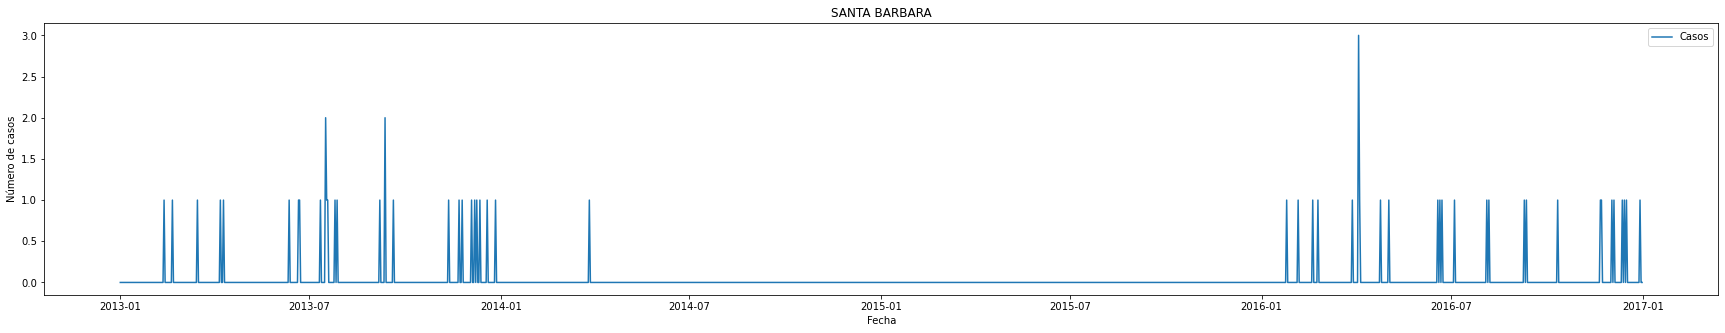

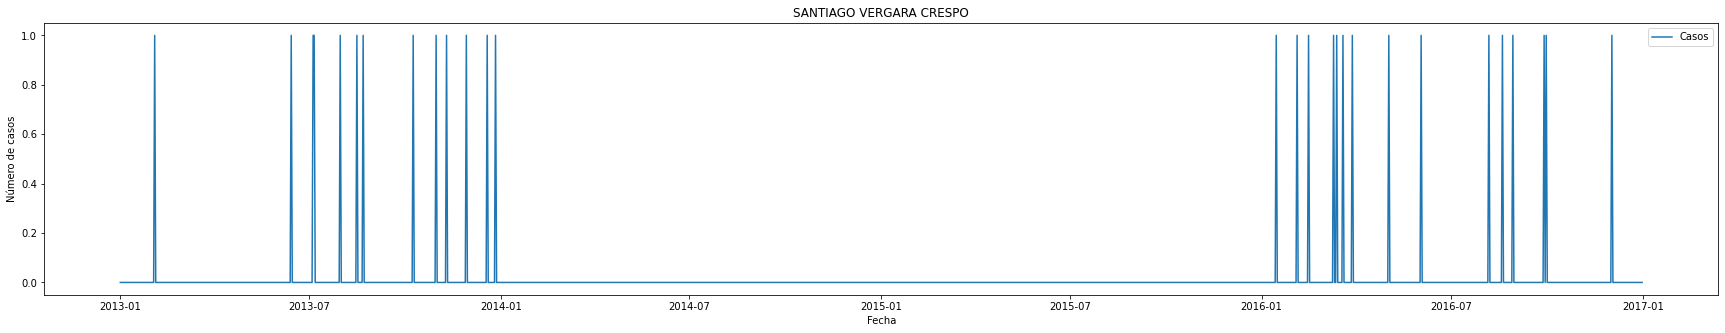

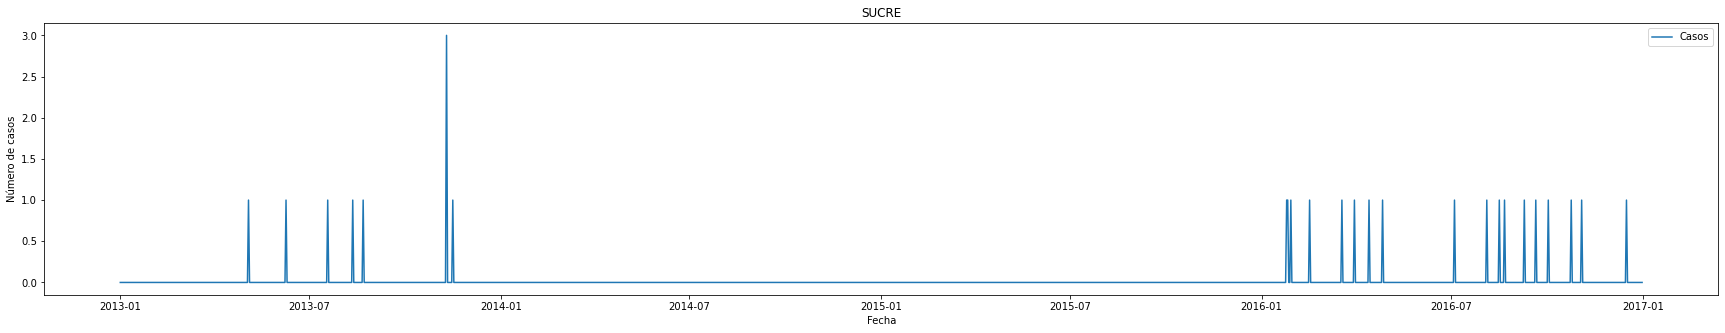

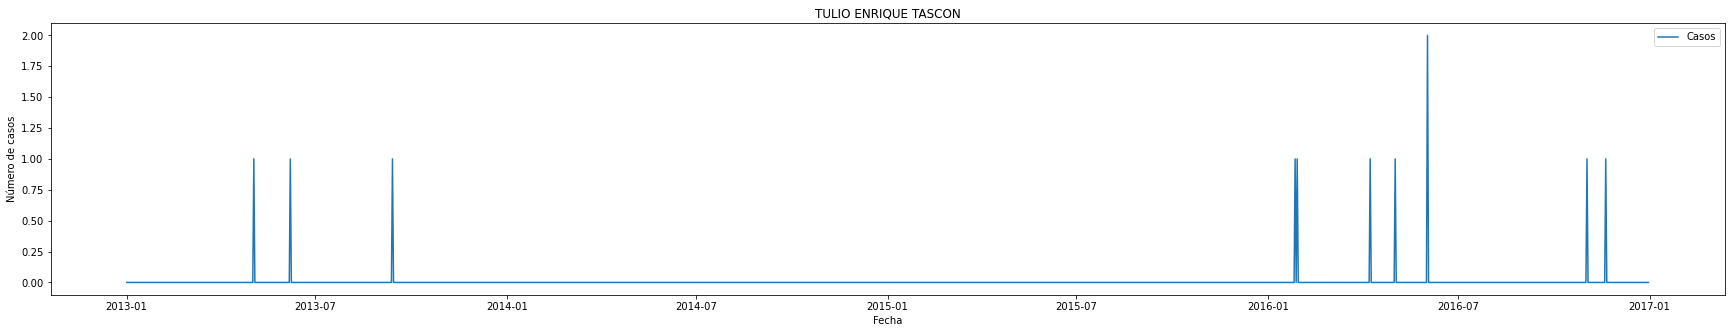

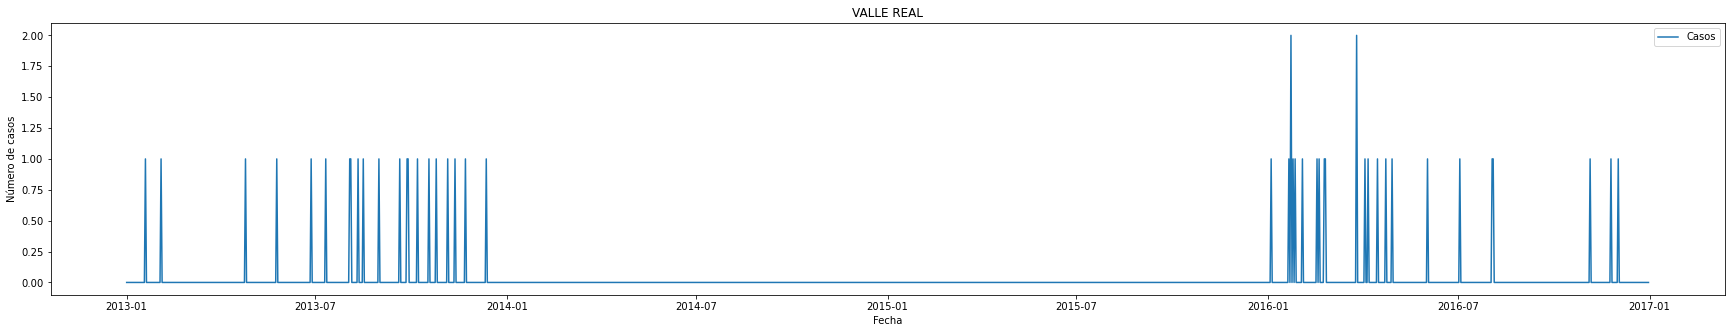

In [7]:
neighborhoods_df = df2['Barrio'].value_counts().sort_index()

for neighborhood_name in neighborhoods_df.index :
    nb_df = df2[df2.Barrio == neighborhood_name]
    h = pd.DataFrame(nb_df['FecNot'].value_counts().sort_index())
    h.columns = ['Casos']
    h.index.name = 'Fecha'
    df_zeros = assign_zeros(h)
    df_zeros.set_index('Fecha',inplace=True)
    stationarity_analysis_nb(df_zeros,neighborhood_name)

**TODAS LAS SERIES DE TIEMPO PARA CADA UNO DE LOS BARRIOS ENTRE 2013 Y 2016 SON ESTACIONARIAS**

## PRUEBAS DE CORRELACIÓN

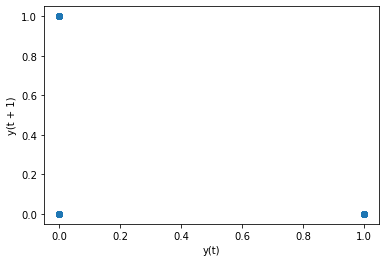

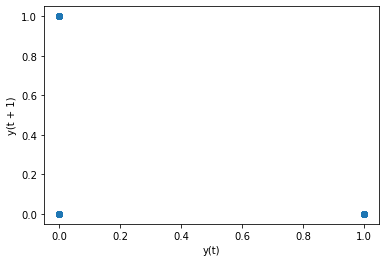

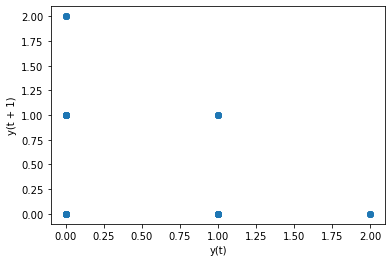

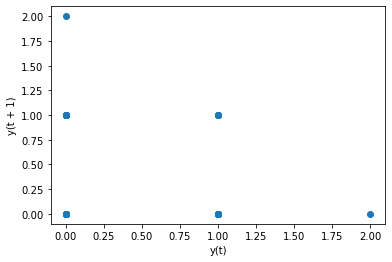

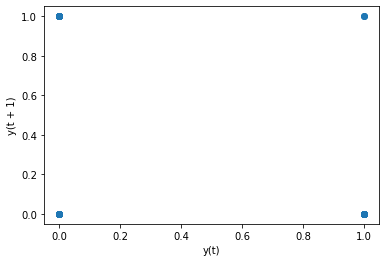

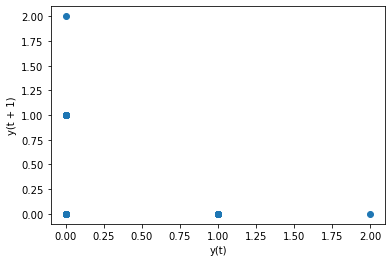

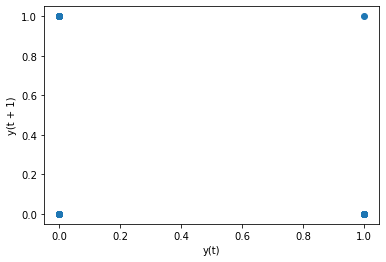

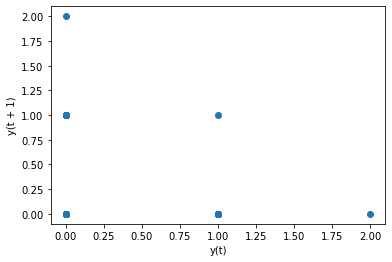

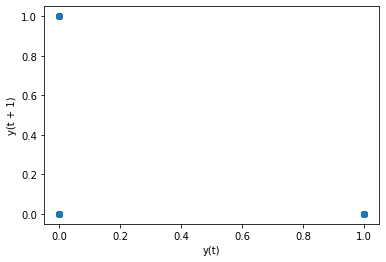

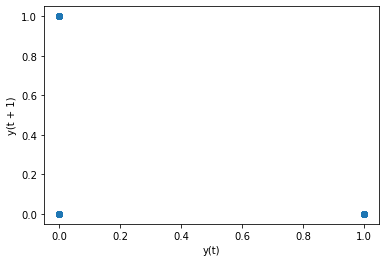

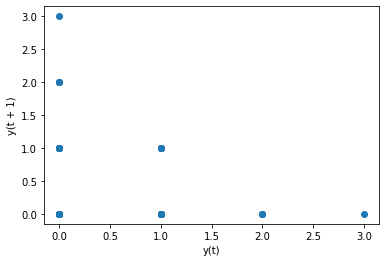

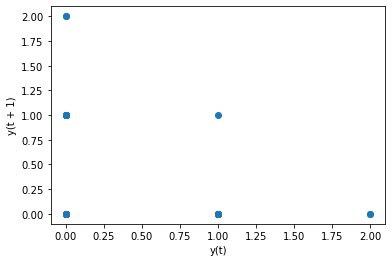

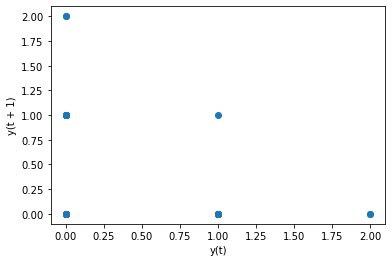

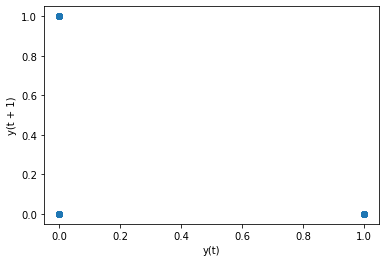

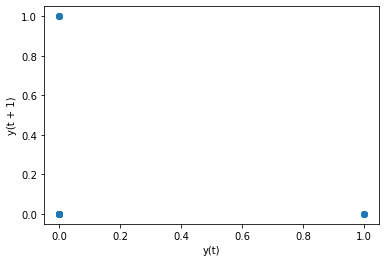

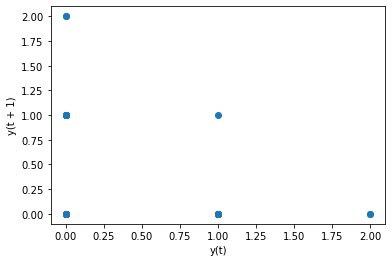

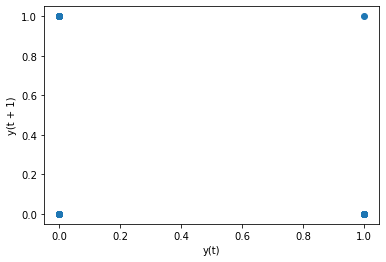

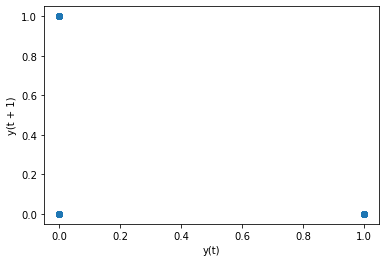

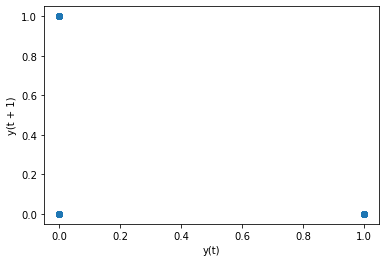

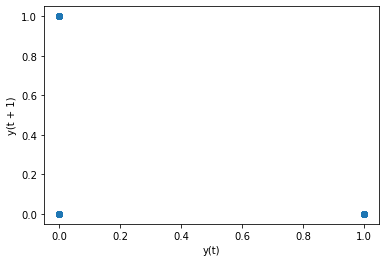

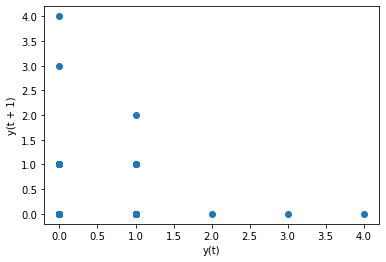

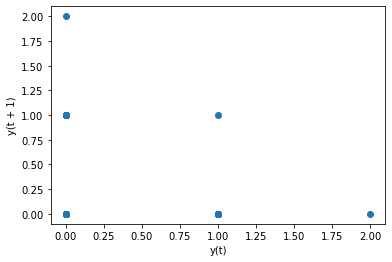

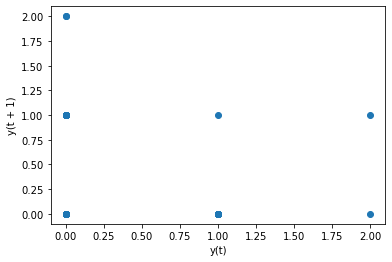

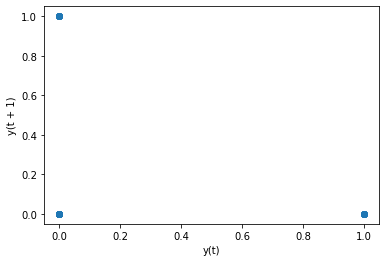

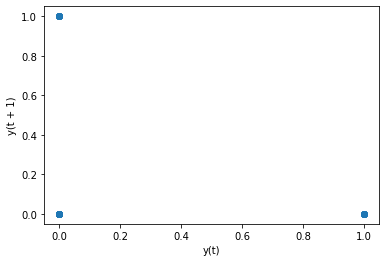

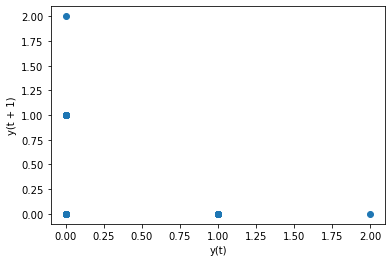

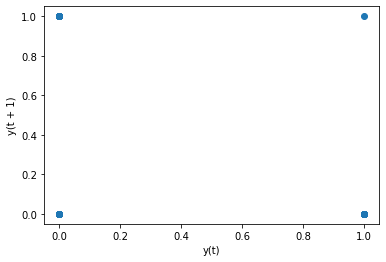

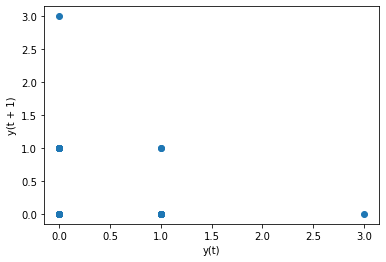

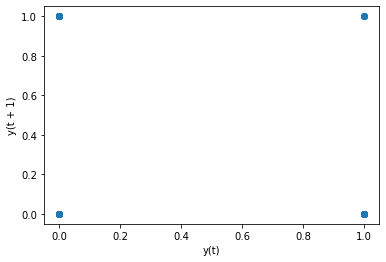

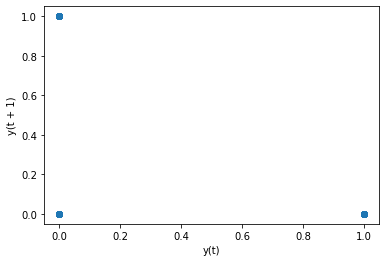

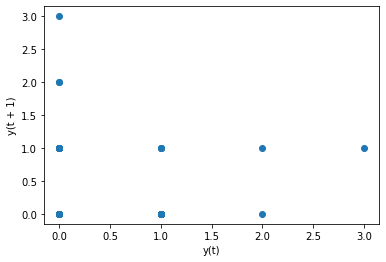

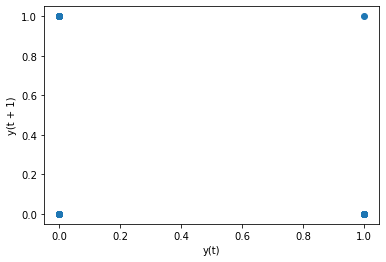

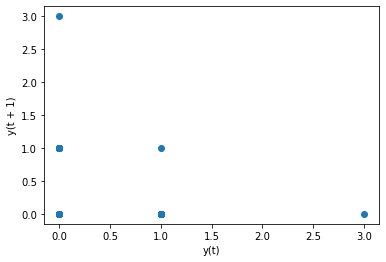

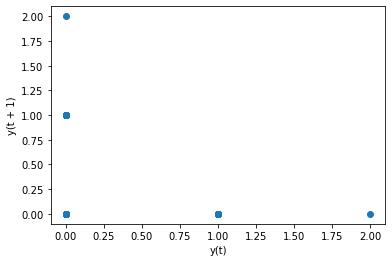

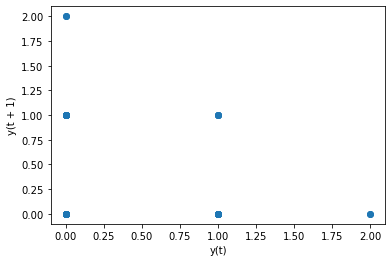

In [8]:
for neighborhood_name in neighborhoods_df.index :
    nb_df = df2[df2.Barrio == neighborhood_name]
    h = pd.DataFrame(nb_df['FecNot'].value_counts().sort_index())
    h.columns = ['Casos']
    h.index.name = 'Fecha'
    df_zeros = assign_zeros(h)
    df_zeros.set_index('Fecha',inplace=True)
    lag_plot(df_zeros)
    plt.show()

## ANÁLISIS

- Los datos filtrados entre 2013 y 2016 para cada barrio no están del todo correlacionados. Poseen un promedio de correlación de 0.25